In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from umap import UMAP

from models import (
    train_ridge,
    train_rf,
    get_metrics
)

np.random.seed(42)

%load_ext autoreload
%autoreload 2

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_domains = 5
n_per_domain = 25
p = 10
noise_scale = 0.5

# just have e_c and e_s be unit vectors
# e_c = np.array([1, 0])
# e_s = np.array([0, 1])

z = np.random.normal(size=(n_domains, p))
z

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
        -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
        -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
         0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375],
       [-0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
        -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124],
       [ 0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
        -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016]])

In [3]:
betas = np.random.uniform(-1, 2, size=(n_domains,))
betas

array([-0.57722733,  1.40659094, -0.77634807,  1.96066081,  1.31673431])

In [4]:
xs = None
ys = None

for i, beta_i in enumerate(betas):
    ys_i = np.random.choice([-1, 1], size=(n_per_domain, 1))
    np.tile((np.array([beta_i]) @ z[[i], :]), (n_per_domain, 1))
    xs_i = (
        np.tile(ys_i, (1, p)) *
        np.tile((np.array([beta_i]) @ z[[i], :]), (n_per_domain, 1))
    ) + (np.random.normal(scale=noise_scale, size=(n_per_domain, p)))
    if xs is None:
        xs = xs_i
    else:
        xs = np.concatenate((xs, xs_i))
    if ys is None:
        ys = ys_i
    else:
        ys = np.concatenate((ys, ys_i))
    
print(xs.shape)
print(xs[:5, :5])

(125, 10)
[[ 0.44775366 -0.48213923  0.10113918 -0.01587622  0.36410226]
 [-0.67656792 -0.34213825 -0.44913045 -1.36191329  0.21040427]
 [ 0.14963557  1.22342292  0.43759673 -0.46726791  0.28168935]
 [ 0.76803763 -0.18465615 -0.01315794  0.69924538  0.2268819 ]
 [-0.36825836  1.39202178 -0.17426938  1.33657661 -0.46819004]]


In [5]:
print(ys.shape)
print(ys[:3, :])

(125, 1)
[[1]
 [1]
 [1]]


In [6]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,14.792356,7.181460,0,1
1,13.936096,7.617830,0,1
2,14.401611,7.965590,0,1
3,15.126870,5.744513,0,-1
4,14.549930,5.676199,0,-1


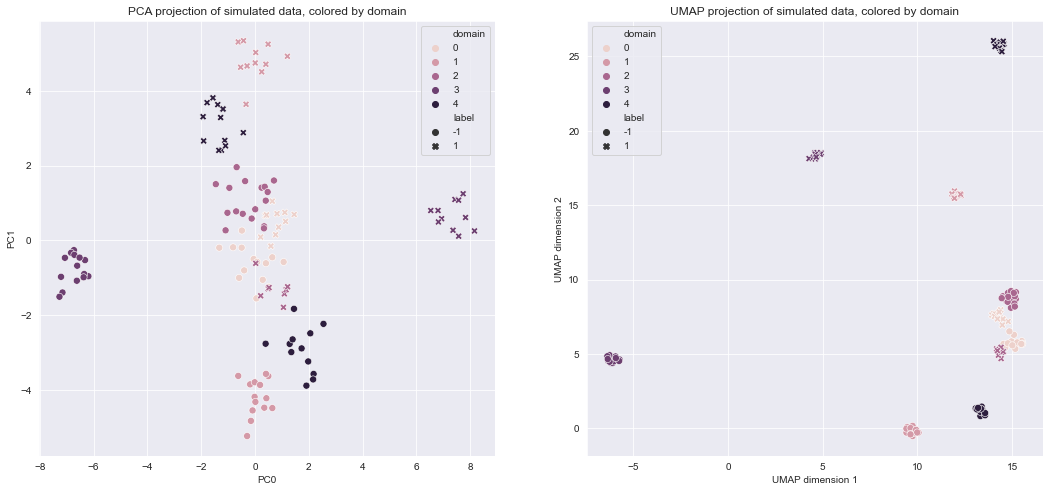

In [7]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

In [8]:
# split dataset into train/test
n_splits = 4
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs)):
    X_train, X_test = xs[train_ix, :], xs[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

,model,fold,metric,value
0,ridge,0,train_auroc,0.881653
1,random_forest,0,train_auroc,0.988095
2,ridge,1,train_auroc,0.863170
3,random_forest,1,train_auroc,1.000000
4,ridge,2,train_auroc,1.000000


(-0.1, 1.1)

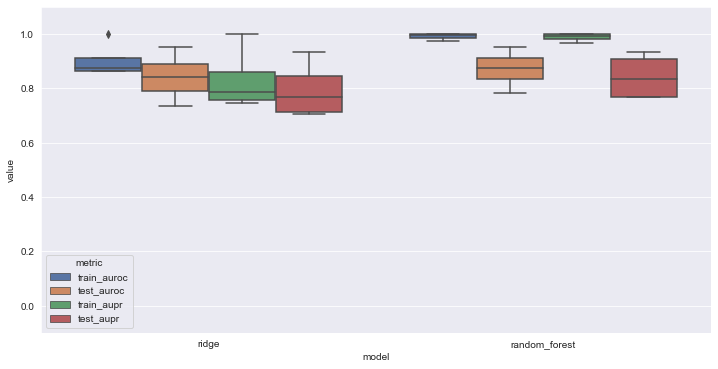

In [9]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)

In [10]:
x_covariates = pd.get_dummies(domains)
x_covariates.head()

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [12]:
xs_fixed = np.concatenate((xs, x_covariates.values), axis=1)
print(xs_fixed[:5, :]) 

[[ 0.44775366 -0.48213923  0.10113918 -0.01587622  0.36410226 -0.70699344
  -0.74814218 -0.48354377  0.50489082  0.05488069  1.          0.
   0.          0.          0.        ]
 [-0.67656792 -0.34213825 -0.44913045 -1.36191329  0.21040427  0.07843962
   0.40519932 -0.95552974 -0.12003047 -0.10120895  1.          0.
   0.          0.          0.        ]
 [ 0.14963557  1.22342292  0.43759673 -0.46726791  0.28168935  0.58346544
  -1.2167258  -0.60106724 -0.47021868 -0.42760424  1.          0.
   0.          0.          0.        ]
 [ 0.76803763 -0.18465615 -0.01315794  0.69924538  0.2268819  -0.26303257
   1.33652539 -0.21267782 -0.70614592  0.05985887  1.          0.
   0.          0.          0.        ]
 [-0.36825836  1.39202178 -0.17426938  1.33657661 -0.46819004 -0.392044
   1.06222619 -0.28627416 -0.6023626   0.23994408  1.          0.
   0.          0.          0.        ]]


In [13]:
# split dataset into train/test
# this time with a covariate for domain membership (this should help performance)
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs_fixed)):
    X_train, X_test = xs_fixed[train_ix, :], xs_fixed[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

,model,fold,metric,value
0,ridge,0,train_auroc,0.881653
1,random_forest,0,train_auroc,1.000000
2,ridge,1,train_auroc,0.872261
3,random_forest,1,train_auroc,1.000000
4,ridge,2,train_auroc,0.796364


(-0.1, 1.1)

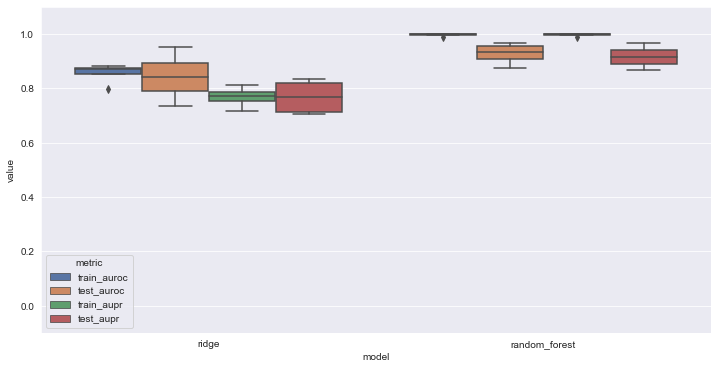

In [14]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)